### Import Packages

In [1]:
import pandas as pd; import os; from analysis_helpers import *; import warnings
from analysis_helpers import *
warnings.filterwarnings('ignore')
import seaborn as sb
import numpy as np
from scipy.interpolate import pchip
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import pingouin

### Load behavioral data

In [3]:
b = pd.read_csv('behav_b.csv') 

### Select desired columns

In [2]:
b = b[b['Trial Type'].isin(['Presentation','Memory'])]
b = b[['Unnamed: 0', 'Attention Button', 'Attention Level', 'Attention Probe',
       'Attention Reaction Time (s)', 'Attention Reaction Time (s).1',
       'Category', 'Cue Validity', 'Cued Category', 'Cued Composite',
       'Cued Face', 'Cued Place', 'Cued Side', 'Experiment',
       'Familiarity Rating', 'Familiarity Reaction Time (s)', 'Group',
       'Memory Image', 'Post Invalid Cue', 'Pre Invalid Cue', 'Rating History',
       'Run', 'Stimulus End', 'Stimulus Onset', 'Subject', 'Trial',
       'Trial Type', 'Uncued Composite', 'Uncued Face', 'Uncued Place',
       'UniqueID', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1']]

### Add last-cued category to memory trials

In [3]:
for idx,x in b[(b['Trial']==9)&(b['Trial Type']=='Presentation')].iterrows():
    b.loc[(b['UniqueID']==x['UniqueID']) &
         (b['Run']==x['Run'])
         &(b['Trial Type']=='Memory'),'Cued Category'] = x['Cued Category']

In [4]:
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Face' ) & (b['Category']=='Face' ), 'Attention Level'] = 'Novel_Cued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Place') & (b['Category']=='Place'), 'Attention Level'] = 'Novel_Cued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Face' ) & (b['Category']=='Place'), 'Attention Level'] = 'Novel_Uncued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Place') & (b['Category']=='Face' ), 'Attention Level'] = 'Novel_Uncued_Cat'  

### Save behavioral data with added info

In [6]:
b.to_csv('behavioral.csv')

### Load gaze data

In [41]:
m = pd.read_csv('mem_gaze_b.csv')

### Calculate mean pupil size (both eyes)

In [ ]:
# pupil pupil data and add mean pupil size to mem gaze dataframe
for eye in ['righteye','lefteye']:
    m[eye] = m[eye].str.split(', ',expand=True)[4]  
    m[eye] = m[eye].str.split(': ',expand=True)[1]
    m[eye] = m[eye].astype(float)

m = m[(m['righteye']>0) & (m['lefteye']>0)]

m['Pupil_mean'] = (m['righteye'] + m['lefteye']) / 2
m['pupil_mean'] = (m['righteye'] + m['lefteye']) / 2

### Add behavioral info to gaze data

In [2]:
# now that we have only good mem trials in the behavioral df
# we want to also subselect just those mem trials in the gaze data

# make empty list
mem_gaze_rest = []
m['Attention Level'],m['Familiarity Rating'],m['Familiarity Reaction Time (s)'],m['good_gaze'], m['Cued Category']=np.nan,np.nan,np.nan,np.nan,np.nan

# now we can loop over each subject
for u in b['UniqueID'].unique():
    
    print(' '); print(u); print('------------')
    
    # select the data for that subject
    f = b[(b['UniqueID']==u)&(b['Trial Type']=='Memory')]
    
    # loop over each run
    for r in f['Run'].unique():
        print(r)
        
        # loop over each trial
        for t in f[(f['Run']==r)]['Trial'].unique():
            
            if f[(f['Run']==r) & (f['Trial']==t)]['Attention Level'].str.contains('Novel').item():
            
                # add behavioral info to 'good gaze' trials in memory gaze dict and label them as 'good gaze'
                m.loc[(m['UniqueID']==u)&(m['Run']==r)&(m['Trial']==t), 'Attention Level'] = b[(b['UniqueID']==u)&(b['Trial Type']=='Memory')&(b['Run']==r)&(b['Trial']==t)]['Attention Level'].item()
                m.loc[(m['UniqueID']==u)&(m['Run']==r)&(m['Trial']==t), 'Familiarity Rating'] = b[(b['UniqueID']==u)&(b['Trial Type']=='Memory')&(b['Run']==r)&(b['Trial']==t)]['Familiarity Rating'].item()
                m.loc[(m['UniqueID']==u)&(m['Run']==r)&(m['Trial']==t), 'Familiarity Reaction Time (s)'] = b[(b['UniqueID']==u)&(b['Trial Type']=='Memory')&(b['Run']==r)&(b['Trial']==t)]['Familiarity Reaction Time (s)'].item()
                m.loc[(m['UniqueID']==u)&(m['Run']==r)&(m['Trial']==t), 'Category'] = b[(b['UniqueID']==u)&(b['Trial Type']=='Memory')&(b['Run']==r)&(b['Trial']==t)]['Category'].item()
                m.loc[(m['UniqueID']==u)&(m['Run']==r)&(m['Trial']==t), 'good_gaze'] = 1
                m.loc[(m['UniqueID']==u)&(m['Run']==r)&(m['Trial']==t), 'Cued Category'] = b[(b['UniqueID']==u)&(b['Trial Type']=='Presentation')&(b['Run']==r)&(b['Trial']==9)]['Cued Category'].unique()

In [84]:
m.to_csv('m_w_behavioral.csv')
# m = pd.read_csv('m_w_behavioral.csv')

### Eliminate cases where Mean Pupil size is zero and Familiarity Reaction Time is zero

In [85]:
mg = m[(m['pupil_mean']>0) & (m['Familiarity Reaction Time (s)']>0)]

### Eliminate cases where gaze location is off the screen

In [86]:
mg['x_righteye'] = (59.8/2048)*mg['xRaw_righteye']
mg['x_lefteye']  = (59.8/2048)*mg['xRaw_lefteye']
mg['y_righteye'] = (33.6/1152)*mg['yRaw_righteye']
mg['y_lefteye']  = (33.6/1152)*mg['yRaw_lefteye']

mg = mg[(mg['x_righteye']>=0) & (mg['x_righteye']<=59.8) 
        &(mg['x_lefteye']>=0) & (mg['x_lefteye']<=59.8) 
        & (mg['y_righteye']<=33.6) & (mg['y_righteye']>=0)
       & (mg['y_lefteye']<=33.6) & (mg['y_lefteye']>=0)]

### Calculate pupil differences

In [87]:
mg['pupil_diff'] = abs(mg['righteye'] - mg['lefteye'])

### Eliminate pupil-difference outliers (IQR based)

In [88]:
# Computing IQR
Q1  = mg['pupil_diff'].quantile(0.25)
Q3  = mg['pupil_diff'].quantile(0.75)
IQR = Q3 - Q1

upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR

mg['IQR_Outlier'] = np.nan
mg.loc[(mg['pupil_diff']<upper) & (mg['pupil_diff']>lower),'IQR_Outlier'] = 0
mg.loc[(mg['pupil_diff']>upper) | (mg['pupil_diff']<lower),'IQR_Outlier'] = 1

In [89]:
# set mg equal to mg without outliers
mg = mg[(mg['IQR_Outlier']==0)]

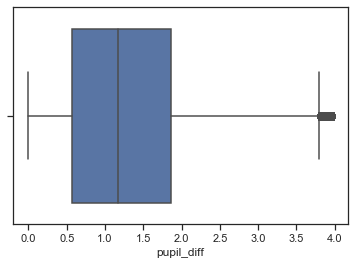

In [90]:
# sb.violinplot(x='pupil_diff', data=mg[mg['IQR_Outlier']==0])
sb.boxplot(x='pupil_diff', data=mg)

### Calculate z-scores

In [91]:
mg['zscore'] = np.nan 

for s in mg['UniqueID'].unique():
    
    subject = mg[(mg['UniqueID']==s) ]
    mg.loc[(mg['UniqueID']==s) , 'zscore'] = (subject.pupil_mean - subject.pupil_mean.mean())/subject.pupil_mean.std(ddof=0)

In [50]:
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Face' ) & (b['Category']=='Face' ), 'Attention Level'] = 'Novel_Cued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Place') & (b['Category']=='Place'), 'Attention Level'] = 'Novel_Cued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Face' ) & (b['Category']=='Place'), 'Attention Level'] = 'Novel_Uncued_Cat'
b.loc[(b['Attention Level']=='Novel') & (b['Cued Category']=='Place') & (b['Category']=='Face' ), 'Attention Level'] = 'Novel_Uncued_Cat'  

In [92]:
mg.loc[(mg['Attention Level']=='Novel') & (mg['Cued Category']=='Face' ) & (mg['Category']=='Face' ), 'Attention Level'] = 'Novel_Cued_Cat'
mg.loc[(mg['Attention Level']=='Novel') & (mg['Cued Category']=='Place') & (mg['Category']=='Place'), 'Attention Level'] = 'Novel_Cued_Cat'
mg.loc[(mg['Attention Level']=='Novel') & (mg['Cued Category']=='Face' ) & (mg['Category']=='Place'), 'Attention Level'] = 'Novel_Uncued_Cat'
mg.loc[(mg['Attention Level']=='Novel') & (mg['Cued Category']=='Place') & (mg['Category']=='Face' ), 'Attention Level'] = 'Novel_Uncued_Cat' 

### Select 'Novel' image trials

In [93]:
mg = mg[mg['Attention Level'].isin(['Novel_Uncued_Cat', 'Novel_Cued_Cat'])] 

### add time_from_onset and time_pre_response to gaze data

In [3]:
mg['timestamp'] = mg.timestamp.astype(float)
mg['time_from_onset'] = np.nan
mg['time_pre_response'] = np.nan

for s in mg['UniqueID'].unique():
    print(s)
    
    data = mg[mg['UniqueID']==s]
    
    for r in data['Run'].unique():
        for t in data[(data['Run']==r)]['Trial'].unique():
            
            this_trial = data[(data['Run']==r) & (data['Trial']==t)]
            mg.loc[(mg['Run']==r) & (mg['Trial']==t) &(mg['UniqueID']==s),'time_from_onset']=this_trial['timestamp']-this_trial.iloc[0]['timestamp']

In [95]:
mg['time_pre_response'] = mg['Familiarity Reaction Time (s)'] - mg['time_from_onset']

In [96]:
mg.to_csv('mg_w_onset_times.csv')
# mg = pd.read_csv('mg_w_onset_times.csv')

### Calculate each trial's average gazepoints per second

In [4]:
mg['gaze_resolution'] = np.nan
mg['max_time'] = np.nan


for s in mg['UniqueID'].unique():
    
    print(s)
    
    for r in mg[(mg['UniqueID']==s)]['Run'].unique():
        for t in mg[(mg['UniqueID']==s) & (mg['Run']==r)]['Trial'].unique():
            
            dat = mg[(mg['UniqueID']==s) & (mg['Run']==r) &(mg['Trial']==t)]
            dat = dat.drop_duplicates('time_from_onset')
            
            mg.loc[(mg['UniqueID']==s) & (mg['Run']==r) &(mg['Trial']==t), 'max_time'] = dat['time_from_onset'].max()
            
            if mg[(mg['UniqueID']==s) & (mg['Run']==r) &(mg['Trial']==t)]['time_from_onset'].max()-mg[(mg['UniqueID']==s) & (mg['Run']==r) &(mg['Trial']==t)]['time_from_onset'].min() != 0:
                mg.loc[(mg['UniqueID']==s) & (mg['Run']==r) &(mg['Trial']==t),'gaze_resolution']=dat.shape[0]/3
                

In [98]:
mg.to_csv('mg_with_resolution.csv')
# mg = pd.read_csv('mg_with_resolution.csv')

### Select trials with an average 20 or more gazepoints per second 

In [99]:
mg_res = mg[(mg['gaze_resolution']>=20)]

### Interpolate gaze data

In [1]:
terpy = []; attention = []; familiarity = []; run = []; trial = []; sub = []
timepoints = []; category = []; cued_category = []

for s in mg_res['UniqueID'].unique():
    print(s)
    for r in mg_res[(mg_res['UniqueID']==s)]['Run'].unique():
        for t in mg_res[(mg_res['UniqueID']==s) & (mg_res['Run']==r)]['Trial'].unique():
            
            dat = mg_res[(mg_res['UniqueID']==s) & (mg_res['Run']==r) & (mg_res['Trial']==t)]
            dat = dat.drop_duplicates('time_from_onset')
            
            x = dat['time_from_onset']
            y = dat['zscore']
            y_val = dat['Pupil_mean']
            
            upper_dat = x.max()
            l = list(np.linspace(0,3,150))
            minnie = min(l, key=lambda x:abs(x-upper_dat))
            i = l.index(minnie)
            xx = l[0:i+1]
            
            if x.shape[0] >= 2:
            
                interp = pchip(x, y)
                yy = interp(xx)
                
                terpy.extend(yy)
                timepoints.extend(xx)
            
                attention.extend(list(dat['Attention Level'].unique())*len(xx))
                category.extend(list(dat['Category'].unique())*len(xx))
                cued_category.extend(list(dat['Cued Category'].unique())*len(xx))
                familiarity.extend(list(dat['Familiarity Rating'].unique())*len(xx))
                run.extend(list(dat['Run'].unique())*len(xx))
                trial.extend(list(dat['Trial'].unique())*len(xx))
                sub.extend(list(dat['UniqueID'].unique())*len(xx))

In [104]:
data_dict = {'Time':timepoints, 'UniqueID':sub, 'Run':run, 'Category': category, 'Cued Category': cued_category, 'Trial':trial,'Interp':terpy, 'Attention Level':attention, 'Familiarity Rating': familiarity}

### Make dataframe

In [105]:
d_nov = pd.DataFrame(data_dict)
d_nov['Experiment'] = np.nan
d_nov.loc[d_nov['UniqueID']<30, 'Experiment']  = 'Sustained'
d_nov.loc[d_nov['UniqueID']>=30, 'Experiment'] = 'Variable'

### Save dataframe

In [106]:
d_nov.to_csv('d_nov_b.csv')